<a href="https://colab.research.google.com/github/kwankoravich/-MLEnd-mini-project/blob/main/MLEnd_Basic_solution__RandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment set up

In this section we will set up a Colab environment for the MLEnd mini-project. Before starting, follow these simple instructions: 

1.   Go to https://drive.google.com/
2.   Create a folder named 'Data' in 'MyDrive'. On the left, click 'New' > 'Folder', enter the name 'Data', and click 'create'
3.   Open the 'Data' folder and create a folder named 'MLEnd'.
4.   Move the file 'trainingMLEnd.csv' to the newly created folder 'MyDrive/Data/MLEnd'.



In [1]:
from google.colab import drive

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os, sys, re, pickle, glob
import urllib.request
import zipfile

#from IPython.display import Audio
import IPython.display as ipd
from tqdm import tqdm
import librosa
drive.mount('/content/drive')

Mounted at /content/drive


Run the following cell to check that the MLEnd folder contains the file 'trainingMLEnd,csv':

In [2]:
path = '/content/drive/MyDrive/Data/MLEnd'
os.listdir(path)

['trainingMLEnd.csv', 'training', 'training.zip']

# Data download

In this section we will download the data that you need to build your solutions. Note that even though we call it "training" dataset you can do whatever you want with it, for instance validation tasks. Note that we keep a separate dataset for testing purposes, which we won't share with anyone.

First, we will define a function that will allow us to download a file into a chosen location.

In [3]:
def download_url(url, save_path):
    with urllib.request.urlopen(url) as dl_file:
        with open(save_path, 'wb') as out_file:
            out_file.write(dl_file.read())

The next step is to download the file 'training.zip' into the folder 'MyDrive/Data/MLEnd'. Note that this might take a while.

In [4]:
#url  = "https://collect.qmul.ac.uk/down?t=6H8231DQL1NGDI9A/613DLM2R3OFV5EEH9INK2OG"
#save_path = '/content/drive/MyDrive/Data/MLEnd/training.zip'
#download_url(url, save_path)

Finally, let's unzip the training file.

In [5]:
#directory_to_extract_to = '/content/drive/MyDrive/Data/MLEnd/training/'
#with zipfile.ZipFile(save_path, 'r') as zip_ref:
    #zip_ref.extractall(directory_to_extract_to)

Once this step is completed, you should have all the audio files in the location 'MyDrive/Data/MLEnd/training/training'. 

# Understanding our dataset

Let's check how many audio files we have in our training dataset:

In [6]:
files = glob.glob('/content/drive/MyDrive/Data/MLEnd/training/*/*.wav')
len(files)

20000

This figure (20k) corresponds to the number of **items** or **samples** in our dataset. Let's listen to some random audio files:

In [7]:
# five random files
for _ in range(5):
  n = np.random.randint(20000)
  display(ipd.Audio(files[n]))

Can you recognise the numeral and intonation? Can you recognise the speaker?

Let's now load the contents of 'trainingMLEnd.csv' into a pandas DataFrame and explore them:

In [8]:
labels = pd.read_csv('/content/drive/MyDrive/Data/MLEnd/trainingMLEnd.csv')
labels

,File ID,digit_label,participant,intonation
0,0000000.wav,4,S73,question
1,0000001.wav,2,S88,excited
2,0000002.wav,70,S5,neutral
3,0000003.wav,2,S85,bored
4,0000004.wav,4,S30,excited
...,...,...,...,...
19995,0019995.wav,90,S163,excited
19996,0019996.wav,10,S99,question
19997,0019997.wav,90,S46,question
19998,0019998.wav,19,S13,neutral


This file consists of 20k rows and 4 columns. Each row corresponds to one of the items in our dataset, and each item is described by four attributes:


1.   File ID (audio file)
2.   Numeral
3.   Participand ID
4.   Intonation

Could you explore this dataset further and identify how many items we have per numeral, per individual and per intonation?

# Feature extraction : Picth

Audio files are complex data types. Specifically they are **discrete signals** or **time series**, consisting of values on a 1D grid. These values are known as *samples* themselves, which might be a bit confusing, as we have used this term to refer to the *items* in our dataset. The **sampling frequency** is the rate at which samples in an audio file are produced. For instance a sampling frequency of 5HZ indicates that 5 produce 5 samples per second, or 1 sample every 0.2 s.

Let's plot one of our audio signals:

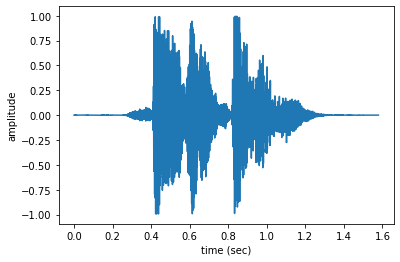

In [9]:
n=0
fs = None # Sampling frequency. If None, fs would be 22050
x, fs = librosa.load(files[n],sr=fs)
t = np.arange(len(x))/fs
plt.plot(t,x)
plt.xlabel('time (sec)')
plt.ylabel('amplitude')
plt.show()
display(ipd.Audio(files[n]))

The file that we are listening to is:

In [10]:
files[n]

'/content/drive/MyDrive/Data/MLEnd/training/Training/0006638.wav'

Can you recognise the numeral and intonation? Compare them with the values for the numeral and intonation that you can find in the `labels` DataFrame. By changing the value of `n` in the previous cell, you can listen to other examples. If you are doing this during one of our lab sessions, please make sure that your mic is muted!

Exactly, how complex is an audio signal? Let's start by looking at the number of samples in one of our audio files:

In [11]:
n=0
x, fs = librosa.load(files[n],sr=fs)
print('This audio signal has', len(x), 'samples')

This audio signal has 34816 samples


If we are using a raw audio signal as a predictor, we will be operating in a predictor space consisting of tens of thousands of dimensions. Compare this figure with the number of samples that we have. Do we have enough samples to train a model that takes one of these audio signals as an input?

One approach is to extract a few features from our signals and use these features instead as predictors. In the following cell, we define a function that extracts four features from an audio signal, namely:


1.   Power.
2.   Pitch mean.
3.   Pitch standard deviation.
4.   Fraction of voiced region.

In the next cell, we define a new function that gets the pitch of an audio signal.

In [12]:
def getPitch(x,fs,winLen=0.02):
  #winLen = 0.02 
  p = winLen*fs
  frame_length = int(2**int(p-1).bit_length())
  hop_length = frame_length//2
  f0, voiced_flag, voiced_probs = librosa.pyin(y=x, fmin=80, fmax=450, sr=fs,
                                                 frame_length=frame_length,hop_length=hop_length)
  return f0,voiced_flag

Let's now consider the problem of identifying a numeral between 0 and 9. Then next cell defines a function that takes a number of files and creates a NumPy array containing the 4 audio features used as predictors (`X`) and their labels (`y`). 

In [13]:
def getXy(files,labels_file,scale_audio=False, onlySingleDigit=False):
  X,y =[],[]
  for file in tqdm(files):
    fileID = file.split('/')[-1]
    yi = list(labels_file[labels_file['File ID']==fileID]['digit_label'])[0]
    if onlySingleDigit and yi>9:
      continue
    else:
      fs = None # if None, fs would be 22050
      x, fs = librosa.load(file,sr=fs)
      if scale_audio: x = x/np.max(np.abs(x))
      f0, voiced_flag = getPitch(x,fs,winLen=0.02)
      
      power = np.sum(x**2)/len(x)
      pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
      pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
      voiced_fr = np.mean(voiced_flag)

      xi = [power,pitch_mean,pitch_std,voiced_fr]
      X.append(xi)
      y.append(yi)
  return np.array(X),np.array(y)

Let's apply `getXy` to the first 500 files. Note that the first 500 files contains numerals outside the [0, 9] range, which we wil be discaarding.

In [14]:
X,y = getXy(files[:500],labels_file=labels,scale_audio=True, onlySingleDigit=True)

# If you want to use all 20000 files, run next line instead
#X,y = getXy(files,labels_file=labels,scale_audio=True, onlySingleDigit=True)

100%|██████████| 500/500 [01:08<00:00,  7.32it/s]


The next cell shows the shape of `X` and `y` and prints the labels vector `y`:

In [15]:
print('The shape of X is', X.shape) 
print('The shape of y is', y.shape)
print('The labels vector is', y)

The shape of X is (155, 4)
The shape of y is (155,)
The labels vector is [7 1 4 9 7 7 4 2 4 8 3 7 5 7 9 5 3 1 5 7 8 9 2 7 3 8 1 5 7 0 5 0 2 0 7 3 3
 4 8 8 0 3 3 9 9 1 9 6 8 6 4 7 6 7 9 6 2 0 1 0 1 7 4 6 1 2 8 0 6 9 9 4 0 5
 5 2 2 1 2 1 7 9 5 1 3 1 7 7 5 1 8 6 3 8 9 9 7 5 1 4 4 5 2 3 9 3 8 4 4 1 2
 0 1 1 7 2 3 7 8 3 0 5 0 8 9 4 9 7 7 1 1 6 9 7 2 6 3 5 1 5 1 1 4 0 0 9 5 4
 0 0 7 1 0 8 0]


Finally, to be on the cautious side, let's eliminate any potential item with a NaN (*not a number*).

In [16]:
# If nan sample, remove them
if np.sum(np.isnan(X)):
  idx = np.isnan(X).sum(1)>0
  X = X[~idx]
  y = y[~idx]
print(np.sum(np.isnan(X)))

0


# Modeling: Random Forest Classification

> Indented block



Let's build a Random Forest model for the predictive task of identifying digits in an audio signal, using the dataset that we have just created.

We will use the RandomForestClassifier() method provided by `scikit-learn` and will split the dataset defined by `X` and `y` into a training set and a validation set.

In [17]:
from sklearn import svm
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.3)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((108, 4), (47, 4), (108,), (47,))

Can you identify the number of items in the training and validation sets?

Let's now fit an SVM model and print both the training accuracty and validation accuracy.

In [18]:
from sklearn.ensemble import RandomForestClassifier
model  = RandomForestClassifier()
model.fit(X_train,y_train)

yt_p = model.predict(X_train)
yv_p = model.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

Training Accuracy 1.0
Validation  Accuracy 0.14893617021276595


Used GridSearchCV to find the best hyperparameter for SVM model.

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

parameters = {'n_estimators':[200,2000], 'max_features':['auto','sqrt'], 'max_depth':[100,500]}
rfc = RandomForestClassifier()
grid = GridSearchCV(rfc, parameters)
# fitting the model for grid search 
grid.fit(X_train, y_train) 
 
# print best parameter after tuning 
print(grid.best_params_) 
grid_predictions = grid.predict(X_val) 
   
# print classification report 
print(classification_report(y_val, grid_predictions)) 

{'max_depth': 500, 'max_features': 'sqrt', 'n_estimators': 2000}
              precision    recall  f1-score   support

           0       0.12      0.14      0.13         7
           1       0.22      0.50      0.31         4
           2       0.50      0.20      0.29         5
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         3
           5       0.00      0.00      0.00         5
           6       0.25      0.33      0.29         3
           7       0.33      0.14      0.20         7
           8       0.00      0.00      0.00         5
           9       0.17      0.20      0.18         5

    accuracy                           0.15        47
   macro avg       0.16      0.15      0.14        47
weighted avg       0.17      0.15      0.14        47



Compare the training and validation accuracies. What do you observe? What do you think the accuracy of a random classifier would be?

Let's normalise the predictors, to see if the performance improves.

In [21]:
mean = X_train.mean(0)
sd =  X_train.std(0)

X_train = (X_train-mean)/sd
X_val  = (X_val-mean)/sd

model  = RandomForestClassifier(max_depth=500, max_features='sqrt',n_estimators=2000)
model.fit(X_train,y_train)

yt_p = model.predict(X_train)
yv_p = model.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

Training Accuracy 1.0
Validation  Accuracy 0.1702127659574468
